In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)
import operator


In [3]:
items = pd.concat([
    pd.read_csv("item_properties_part1.csv"),
    pd.read_csv("item_properties_part2.csv")
])
events = pd.read_csv('events.csv')
category_tree = pd.read_csv('category_tree.csv')

events — датасет с событиями. Колонки:

* timestamp — время события
* visitorid — идентификатор пользователя
* event — тип события
* itemid — идентификатор объекта
* transactionid — идентификатор транзакции, если она проходила

category_tree — файл с деревом категорий (можно восстановить дерево).

* category_id — идентификатор категорий
* parent_id — идентификатор родительской категории

item_properties — файл с свойствами товаров.

* timestamp — момент записи значения свойства
* item_id — идентификатор объекта
* property — свойство
* value — значение свойства

## EDA

In [3]:
print(items.shape)
items.head(5)

(20275902, 4)


,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


In [4]:
print(events.shape)
events.head(5)

(2756101, 5)


,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [5]:
print(category_tree.shape)
category_tree.head(5)

(1669, 2)


,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


Посмотрим сколько уникальных транзакций и транзакций в целом:

In [6]:
print(events["transactionid"].dropna().unique().shape[0])
print(events["transactionid"].dropna().shape[0])

17672
22457


Видно, что большая часть транзакций была разовая и всего около 5 тыс. транзакий повторялись. Следовательно, использовать метод анализа рыночной корзины(MBA) не получится.

Посмторим количество уникальных товаров:

In [7]:
print(events["itemid"].unique().shape[0])

235061


Посмотрим на баланс действий:

event
view           2664312
addtocart        69332
transaction      22457
Name: count, dtype: int64


<Axes: title={'center': 'Add-to-cart V/s Transaction'}, xlabel='event'>

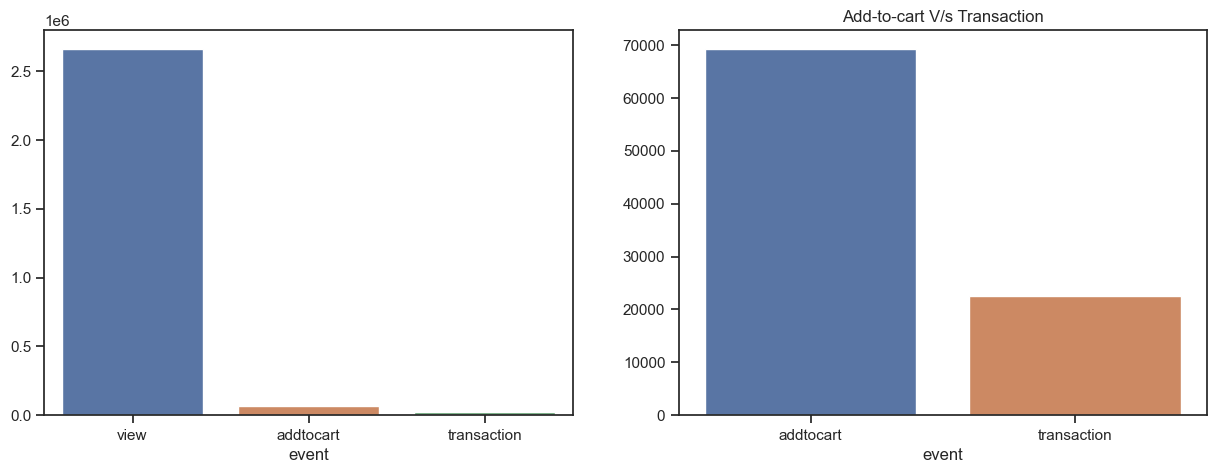

In [4]:
events_count=events["event"].value_counts()
fig, axs = plt.subplots(ncols=2,figsize=(15, 5))
sns.barplot(x=events_count.index, y=events_count.values, ax=axs[0])

print(events_count)

events_count=events["event"].value_counts()[1:]
plt.title('Add-to-cart V/s Transaction')
sns.barplot(x=events_count.index, y=events_count.values)

Как видно просмотров на порядки больше чем, транзакций и добавлений в корзину. Транзакции составлют примерно треть от добавлений в корзину.

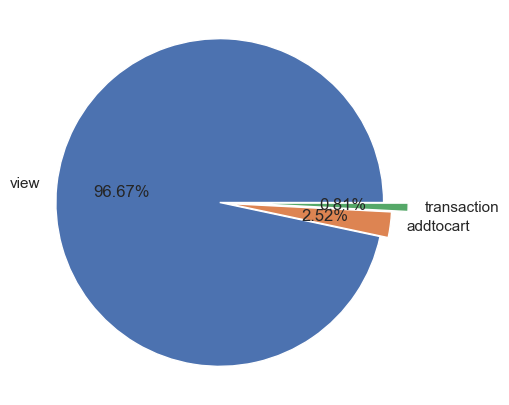

In [9]:
data = events.event.value_counts()
labels = data.index
sizes = data.values
explode = (0, 0.05, 0.15)
fig, ax = plt.subplots(figsize=(5,5))

patches, texts, autotexts = ax.pie(sizes, labels=labels, explode=explode, autopct='%1.2f%%', shadow=False, startangle=0) 

ax.axis('equal')
plt.show()

Посмотрим на самые просматриваемые товары: 

<Axes: >

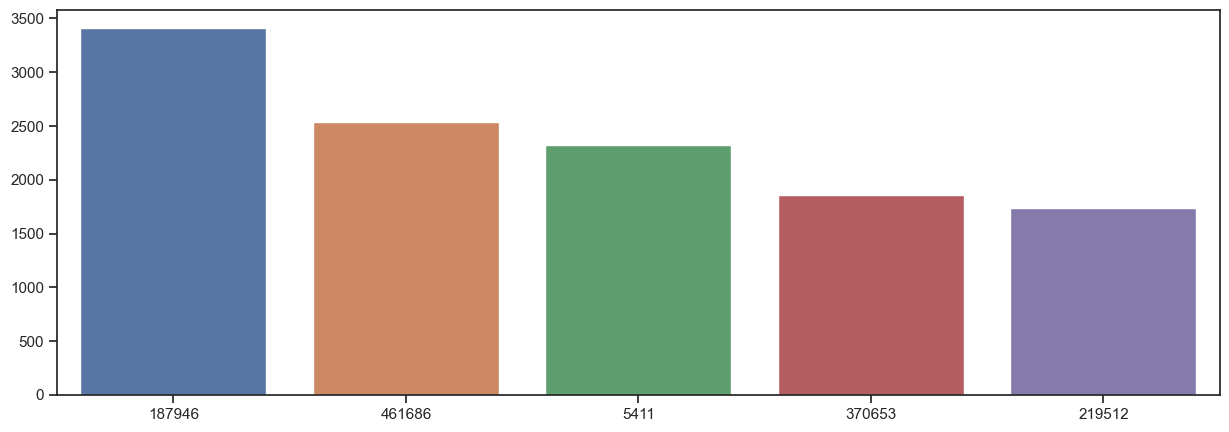

In [10]:
grouped=events.groupby('event')['itemid'].apply(list)

views=grouped['view']
count_view={}
views=np.array(views[:]) 

unique, counts = np.unique(views, return_counts=True)
count_view=dict(zip(unique, counts))
sorted_count_view =sorted(count_view.items(), key=operator.itemgetter(1),reverse=True)
x=[i[0] for i in sorted_count_view[:5]]
y=[i[1] for i in sorted_count_view[:5]]

fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(x=x,y=y,order=x)

Самые добавляемые товары:

<Axes: >

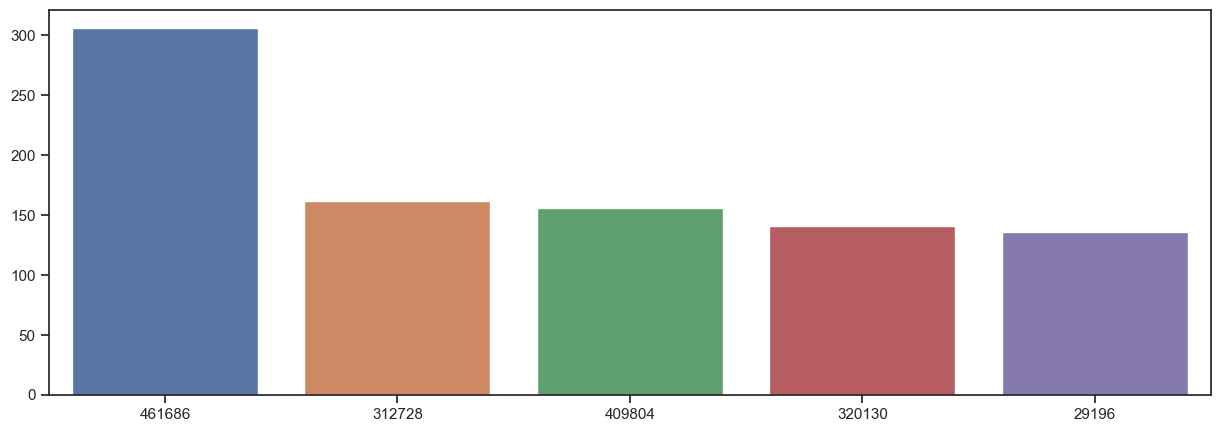

In [11]:
addtocart=grouped['addtocart']
count_addtocart={}

addtocart=np.array(addtocart[:])
unique, counts = np.unique(addtocart, return_counts=True)
count_addtocart=dict(zip(unique, counts))

sorted_count_addtocart =sorted(count_addtocart.items(), key=operator.itemgetter(1),reverse=True)
x=[i[0] for i in sorted_count_addtocart[:5]]
y=[i[1] for i in sorted_count_addtocart[:5]]

fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(x=x,y=y, order=x)

Самые продаваемые товары:

<Axes: >

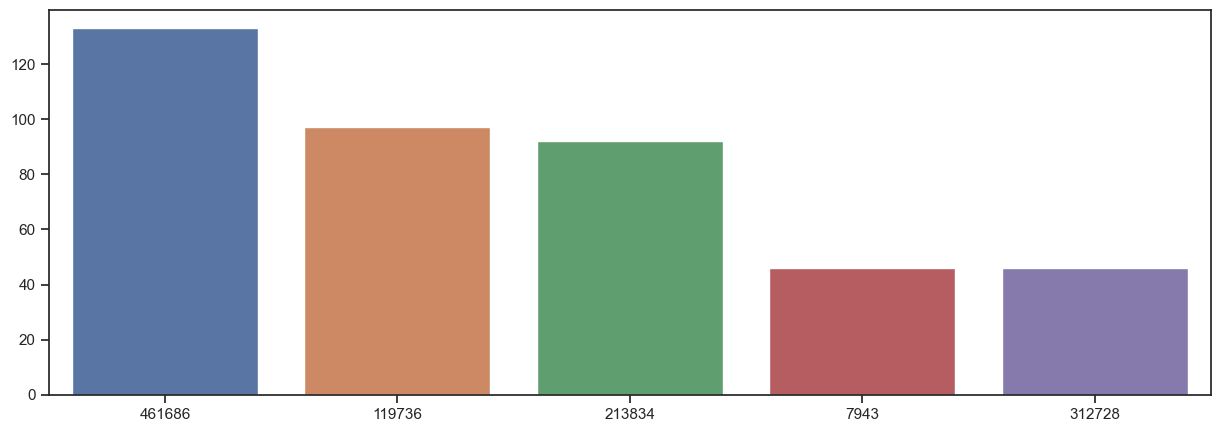

In [12]:
transaction=grouped['transaction']
count_transaction={}

transaction=np.array(transaction[:])
unique, counts = np.unique(transaction, return_counts=True)
count_transaction=dict(zip(unique, counts))

sorted_count_transaction =sorted(count_transaction.items(), key=operator.itemgetter(1),reverse=True)
x=[i[0] for i in sorted_count_transaction[:5]]
y=[i[1] for i in sorted_count_transaction[:5]]

fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(x=x,y=y, order=x)

## Model

In [5]:
from lightfm import LightFM
from lightfm.evaluation import auc_score
from scipy.sparse import coo_matrix, csr_matrix
from sklearn import preprocessing
import datetime

d:\python 3.10\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [6]:
events = events.assign(date=pd.Series(datetime.datetime.fromtimestamp(i/1000).date() for i in events.timestamp))
events = events.sort_values('date').reset_index(drop=True)
events = events[['visitorid','itemid','event', 'date']]
events.head(5)

,visitorid,itemid,event,date
0,567743,42875,view,2015-05-03
1,190672,259357,view,2015-05-03
2,1127598,69533,view,2015-05-03
3,180270,379359,view,2015-05-03
4,425526,440984,view,2015-05-03


In [7]:
start_date = '2015-5-3'
end_date = '2015-5-18'
fd = lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').date()
events = events[(events.date >= fd(start_date)) & (events.date <= fd(end_date))]

Сделаем сплит по времени(80/20):

In [8]:
split_point = int(np.round(events.shape[0]*0.8))
events_train = events.iloc[0:split_point]
events_test = events.iloc[split_point::]
events_test = events_test[(events_test['visitorid'].isin(events_train['visitorid']))
                          & (events_test['itemid'].isin(events_train['itemid']))]

In [9]:
print(events_train.shape[0])
print(events_test.shape[0])

254480
10536


Закодируем признаки:

In [10]:
id_cols=['visitorid','itemid']
trans_cat_train=dict()
trans_cat_test=dict()

for k in id_cols:
    cate_enc=preprocessing.LabelEncoder()
    trans_cat_train[k]=cate_enc.fit_transform(events_train[k].values)
    trans_cat_test[k]=cate_enc.transform(events_test[k].values)

In [11]:
ratings = dict()

cate_enc=preprocessing.LabelEncoder()
ratings['train'] = cate_enc.fit_transform(events_train.event)
ratings['test'] = cate_enc.transform(events_test.event)

Создадим матрицу item-users:

In [13]:
n_users=len(np.unique(trans_cat_train['visitorid']))
n_items=len(np.unique(trans_cat_train['itemid']))

In [14]:
rate_matrix = dict()

#используем разреженные матрицы
rate_matrix['train'] = csr_matrix((ratings['train'],
                                   (trans_cat_train['visitorid'],
                                    trans_cat_train['itemid'])),
                                  shape=(n_users,n_items)
                                  )

rate_matrix['test'] = csr_matrix((ratings['test'],
                                  (trans_cat_test['visitorid'],
                                   trans_cat_test['itemid'])),
                                 shape=(n_users,n_items)
                                 )

Используем LightFM для матричной факторизации:

In [15]:
model = LightFM(no_components=10, loss='logistic', random_state=42)
model.fit(rate_matrix['train'], epochs=50)

In [23]:
#auc_score(model, rate_matrix['train']).mean()

In [16]:
auc_score(model, rate_matrix['test']).mean()

0.7935716

In [17]:
from lightfm.evaluation import precision_at_k

In [18]:
map_at10 = precision_at_k(model, rate_matrix['test'], k=3).mean()
print('Mean Average Precision at 10: {:.5f}'.format(map_at10))

Mean Average Precision at 10: 0.00061


In [21]:
unique_items = np.unique(trans_cat_train['itemid'])
item_ids = np.arange(0, rate_matrix['train'].shape[1])
user_id = 1
list_pred = model.predict(user_id, item_ids)
recomendations_ids = np.argsort(-list_pred)[:10]
recomendations = unique_items[recomendations_ids]
print('Recomendations for user {}: {}'.format(user_id, recomendations))

Recomendations for user 1: [56791 45692 51440 31061 67224 14805 20473 23136 14032 48737]


In [19]:
from implicit.als import AlternatingLeastSquares
from implicit.evaluation import mean_average_precision_at_k

model2 = AlternatingLeastSquares(factors=10, random_state=42)
model2.fit(rate_matrix['train'])

  0%|          | 0/15 [00:00<?, ?it/s]

In [22]:
user_id = 1
recomendations_ids, scores = model2.recommend(user_id, rate_matrix['train'][user_id])
recomendations = unique_items[recomendations_ids]
print('Recomendations ids: {}'.format(recomendations_ids))
print('Recomendations for user {}: {}'.format(user_id, recomendations))

Recomendations ids: [56602 52679 31132  9324 18259 36035 10178 52806  3972  6397]
Recomendations for user 1: [56602 52679 31132  9324 18259 36035 10178 52806  3972  6397]


In [23]:
map_at10 = mean_average_precision_at_k(model2, rate_matrix['train'], rate_matrix['test'], K=3)
print('Mean Average Precision at 10: {:.5f}'.format(map_at10))

  0%|          | 0/3274 [00:00<?, ?it/s]

Mean Average Precision at 10: 0.00424


In [29]:
from implicit.evaluation import AUC_at_k
AUC_at_k(model2, rate_matrix['train'], rate_matrix['test'], K=100)

  0%|          | 0/3274 [00:00<?, ?it/s]

0.5150326379732526

In [31]:
import pickle

with open('ALS_model.pkl', 'wb') as output:
    pickle.dump(model2, output)

In [33]:
with open('ALS_model.pkl', 'rb') as pkl_file:
    ALS_from_file = pickle.load(pkl_file)

In [35]:
user_id = 1
recomendations_ids, scores = ALS_from_file.recommend(user_id, rate_matrix['train'][user_id])
recomendations = unique_items[recomendations_ids]
print('Recomendations ids: {}'.format(recomendations_ids))
print('Recomendations for user {}: {}'.format(user_id, recomendations))

Recomendations ids: [56602 52679 31132  9324 18259 36035 10178 52806  3972  6397]
Recomendations for user 1: [56602 52679 31132  9324 18259 36035 10178 52806  3972  6397]


In [40]:
with open('unique_items.pkl', 'wb') as output:
    pickle.dump(unique_items, output)

In [43]:
with open('rate_matrix.pkl', 'rb') as pkl_file2:
    rate_matrix_from_file = pickle.load(pkl_file2)
    
user_id = 44
recomendations_ids, scores = ALS_from_file.recommend(user_id, rate_matrix_from_file[user_id])
recomendations = unique_items[recomendations_ids]
print('Recomendations ids: {}'.format(recomendations_ids))
print('Recomendations for user {}: {}'.format(user_id, recomendations))

Recomendations ids: [ 5611 68172 48996   971 41818 63359 52679  3972 13646 18792]
Recomendations for user 44: [ 5611 68172 48996   971 41818 63359 52679  3972 13646 18792]


In [55]:
with open('rate_matrix.pkl', 'rb') as pkl_file:
    rate_matrix = pickle.load(pkl_file)

In [47]:
with open('unique_items.pkl', 'rb') as pkl_file2:
    unique_items_from_file = pickle.load(pkl_file2)